In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

In [2]:
import glob
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from itertools import combinations, permutations, product

from math import sqrt
from pmdarima import auto_arima
from src.utils import util as utl
from sklearn.metrics import mean_absolute_error, r2_score


global companies_set 

warnings.filterwarnings('ignore')

# 1 - Análise dos mercados (independente da empresa)

In [3]:
door_dir = glob.glob(r"D:\Documentos_D\UFCG\2021.2e\TCC\Project\analise_de_indicador_tcc_ufcg\data\processed\**\*" + ".csv", recursive=True)

df = pd.DataFrame()

for file_path in door_dir:
    temp_df = pd.read_csv(file_path)
    df = df.append(temp_df)

df = df.reset_index().drop(['index'], axis=1)
df['Volume_Venda'] = df['Volume_Venda'].round(2)


In [4]:
dfm = pd.DataFrame()
temp_df = df[((df.Mercado == 'AN') & (df.Empresa == 'E2'))].reset_index().drop(['index'],axis=1)

dfm['Data'] = temp_df.Data
dfm['Data'] = pd.to_datetime(dfm.Data)

# ----------------------------------------------------AN:
r1_bc = df[((df.Mercado == 'AN') & (df.Empresa == 'E1'))].Volume_Venda.astype(float).to_frame()
r1_br = df[((df.Mercado == 'AN') & (df.Empresa == 'E2'))].Volume_Venda.reset_index().drop(['index'], axis=1).astype(float)

dfm['AN'] = r1_bc.add(r1_br,axis=0)
# ----------------------------------------------------AS:
r2_bi = df[((df.Mercado == 'AS') & (df.Empresa == 'E3'))].Volume_Venda.reset_index().drop(['index'], axis=1).astype(float)
r2_br = df[((df.Mercado == 'AS') & (df.Empresa == 'E2'))].Volume_Venda.reset_index().drop(['index'], axis=1).astype(float)

r2_bt_temp = pd.DataFrame(columns=['Volume_Venda'])
values = []
for i in range(18):
    values.append(0)
r2_bt_temp['Volume_Venda'] = values
r2_bt = df[((df.Mercado == 'AS') & (df.Empresa == 'E4'))].Volume_Venda.reset_index().drop(['index'], axis=1).astype(float)
r2_bt = r2_bt.append(r2_bt_temp).reset_index().drop(['index'], axis=1)

dfm['AS'] = r2_bi.add(r2_br,axis=0)
dfm['AS'] = dfm['AS'] + r2_bt['Volume_Venda']
# ----------------------------------------------------EU:
r3_bi = df[((df.Mercado == 'EU') & (df.Empresa == 'E3'))].Volume_Venda.reset_index().drop(['index'], axis=1).astype(float)
r3_br = df[((df.Mercado == 'EU') & (df.Empresa == 'E2'))].Volume_Venda.reset_index().drop(['index'], axis=1).astype(float)

dfm['EU'] = r3_bi.add(r3_br,axis=0)
# ----------------------------------------------------AL:
r4_br_temp = pd.DataFrame(columns=['Volume_Venda'])
values = []
for i in range(13):
    values.append(0)
r4_br_temp['Volume_Venda'] = values
r4_br = df[((df.Mercado == 'AL') & (df.Empresa == 'E2'))].Volume_Venda.reset_index().drop(['index'], axis=1).astype(float)
r4_br = r4_br.append(r4_br_temp).reset_index().drop(['index'], axis=1)

r4_bt_temp = pd.DataFrame(columns=['Volume_Venda'])
values = []
for i in range(18):
    values.append(0)
r4_bt_temp['Volume_Venda'] = values
r4_bt = df[((df.Mercado == 'AL') & (df.Empresa == 'E4'))].Volume_Venda.reset_index().drop(['index'], axis=1).astype(float)
r4_bt = r4_bt.append(r4_bt_temp).reset_index().drop(['index'], axis=1)

dfm['AL'] = r4_br.add(r4_bt,axis=0)
# ----------------------------------------------------JP:
r5_bi_temp = pd.DataFrame(columns=['Volume_Venda'])
values = []
for i in range(56):
    values.append(0)
r5_bi_temp ['Volume_Venda'] = values
r5_bi = df[((df.Mercado == 'JP') & (df.Empresa == 'E3'))].Volume_Venda.reset_index().drop(['index'], axis=1).astype(float)
r5_bi = r5_bi_temp.append(r5_bi).reset_index().drop(['index'], axis=1)

r5_br = df[((df.Mercado == 'JP') & (df.Empresa == 'E2'))].Volume_Venda.reset_index().drop(['index'], axis=1).astype(float)

r5_bt_temp = pd.DataFrame(columns=['Volume_Venda'])
values = []
for i in range(18):
    values.append(0)
r5_bt_temp ['Volume_Venda'] = values
r5_bt = df[((df.Mercado == 'JP') & (df.Empresa == 'E4'))].Volume_Venda.reset_index().drop(['index'], axis=1).astype(float)
r5_bt = r5_bt.append(r5_bt_temp ).reset_index().drop(['index'], axis=1)

dfm['JP'] = r5_bi.add(r5_br, axis=0)
dfm['JP'] = dfm['JP'] + r5_bt['Volume_Venda']
# ----------------------------------------------------BRL:
r6_br = df[((df.Mercado == 'BRL') & (df.Empresa == 'E2'))].Volume_Venda.reset_index().drop(['index'], axis=1).astype(float)
dfm['BRL'] = r6_br

# ----------------------------------------------------Indefinido:
indefinido = df[((df.Mercado == 'Indefinido'))].Volume_Venda.reset_index().drop(['index'], axis=1).astype(float)
dfm['Indefinido'] = indefinido

dfm = dfm.set_index('Data')

display(dfm.head(5))

,AN,AS,EU,AL,JP,BRL,Indefinido
Data,,,,,,,
2012-01-01,9498.0,27964.0,91330.0,1638.0,38716.0,4598.0,83690.0
2012-02-01,22596.0,26910.0,75416.0,1248.0,59352.0,4192.0,92190.0
2012-03-01,23424.0,67078.0,77030.0,1742.0,52372.0,4664.0,111940.0
2012-04-01,21276.0,12912.0,78790.0,1118.0,0.0,4584.0,53454.0
2012-05-01,22946.0,36676.0,64634.0,2704.0,98688.0,4754.0,115438.0


In [5]:
markets_names = ['AN','AS','EU','AL','JP','BRL'] # O mercado 'Indefinido' será desconsiderado;
markets_values = []
for market_name in markets_names:  
    values_market_df = dfm[market_name]
    markets_values.append(values_market_df.to_frame())

In [6]:
# Criando  volume de dados para treinamento do mercado da América Latina ('AL'):
date_indexes = []
sales_values = []

for market_values_df, market_name in zip(markets_values, markets_names):
    if market_name in ['AL']:
        temp_df =  market_values_df
        for i, row in temp_df.iterrows():
            date = i
            value = row['AL']

            if date < pd.Timestamp('2016-01-01'): # Coletando valores até 01/12/2015;
                date_indexes.append(i)
                sales_values.append(value)

df_AL = pd.DataFrame()
df_AL['Data'] =  date_indexes
df_AL['AL'] =  sales_values
df_AL = df_AL.set_index('Data')
markets_values[3] = df_AL

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.tsa.stattools import adfuller

p_values = []

#Verificando estacionariedade com adfuller:
for market_values_df, market_name in zip(markets_values, markets_names):
    series = market_values_df
    X = series.values
    train, test = X[1:len(X)-12], X[len(X)-12:]
    result = adfuller(train, autolag='AIC')
    p_values.append((market_name,np.round(result[0],4),np.round(result[1],4)))

print(p_values)

[('AN', -2.2539, 0.1873), ('AS', -1.2533, 0.6503), ('EU', -9.579, 0.0), ('AL', -4.8412, 0.0), ('JP', -6.4335, 0.0), ('BRL', -0.9724, 0.7632)]


In [8]:
# Utilizando a bilbioteca autoARIMA para verificar a sugestão de melhor modelo de ARIMA para os seis mercados:

for market_values_df, market_name in zip(markets_values, markets_names):
    print("Mercado: ", market_name)
    X = market_values_df.values
    train, test = X[1:len(X)-12], X[len(X)-12:]
    model = auto_arima(train, start_P=0, start_q=0, stepwise=True, trace=True)

Mercado:  AN
Performing stepwise search to minimize aic
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2176.167, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2227.275, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2196.612, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2160.338, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2225.319, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2161.701, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2161.651, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2160.097, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2161.189, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2162.794, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2194.726, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.133 seconds
Mercado:  AS
Perfor

In [9]:
windows_lags = []
for wg in product([1,2,3,4,5,6,7,8,9,10,11,12], repeat = 2):
    windows_lags.append(wg)

In [10]:
from statsmodels.tsa.ar_model import AutoReg

maes_autoreg = []
r2s_autoreg = []

results_autoreg ={}

for market_values_df, market_name in zip(markets_values, markets_names): 
    # Separando o dataset entre treino e teste:
    series = market_values_df
    X = series.values
    train, test = X[1:len(X)-12], X[len(X)-12:]

    wgs_autoreg = []
    for wg in windows_lags:
        # Treinando a autoregressão:
        window = wg[0]
        lags = wg[1]

        if lags >= window:
            model = AutoReg(train, lags=lags)
            model_fit = model.fit()
            coef = model_fit.params

            # Caminhando sobre o dataset de teste para comparar o valor real com o predito:
            history = train[len(train)-window:]
            history = [history[i] for i in range(len(history))]
            predictions = []

            try: 
                for t in range(len(test)):
                    length = len(history)
                    lag = [history[i] for i in range(length-window,length)]
                    yhat = coef[0]

                    for d in range(window):
                        yhat += coef[d+1] * lag[window-d-1]

                    obs = test[t]
                    predictions.append(yhat)
                    history.append(obs)
                    # print('predicted=%f, expected=%f' % (yhat, obs))
            except:
                print('Window: ', window)
                print('Lags: ', lags )

            mae = mean_absolute_error(test, predictions)
            maes_autoreg.append(mae)

            r2_scr = r2_score(test, predictions)
            r2s_autoreg.append(r2_scr)

            wgs_autoreg.append((wg, r2_scr, mae))

            # print("r²: ", r2_scr)
            # print("mae: ", mae)
                    
            # # Plotando dados:
            # plt.plot(test)
            # plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9,10,11],labels=[1,2,3,4,5,6,7,8,9,10,11,12])
            # plt.title("Autoregressão Simples - " + market_name)
            # plt.xlabel("Mês")
            # plt.ylabel("Volume de Venda (t)")
            # plt.plot(predictions, color='red')
            # plt.show()
    results_autoreg[market_name] = wgs_autoreg 

In [11]:
res_autoreg = []
for key in results_autoreg.keys():
    temp_order = []
    temp_r2 = []
    temp_mae = []
    for tpl in results_autoreg[key]:
        order = tpl[0]
        r2 = tpl[1]
        mae = tpl[2]

        temp_order.append(order)
        temp_r2.append(r2)
        temp_mae.append(mae)

    max_pos = temp_r2.index(max(temp_r2))
    res_autoreg.append((key, temp_order[max_pos], temp_r2[max_pos], temp_mae[max_pos]))

print(res_autoreg)

[('AN', (4, 5), -0.22352231584853555, 5217.76336581503), ('AS', (1, 1), 0.018816720191695002, 18327.692132181463), ('EU', (7, 7), 0.03690809379194193, 13378.434769363352), ('AL', (1, 3), 0.016623693248183358, 1059.2329104133712), ('JP', (11, 12), -0.7371376591827148, 12206.520292484514), ('BRL', (5, 5), 0.15798845878579248, 419.4575960688473)]


In [12]:
orders = []
for ord in product([0,1,2,3,4,5,6,7,8,9,10,11,12], repeat = 3):
    if ord[1] == 0:
        orders.append(ord)

print(orders)
# comb = list(permutations([0,1,2,3,4,5,6,7,8,9,10,11,12],3))
# orders = []
# for p in comb:
#     if p[1] == 0:
#         orders.append(p)

# print(orders)



[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 0, 4), (0, 0, 5), (0, 0, 6), (0, 0, 7), (0, 0, 8), (0, 0, 9), (0, 0, 10), (0, 0, 11), (0, 0, 12), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 0, 3), (1, 0, 4), (1, 0, 5), (1, 0, 6), (1, 0, 7), (1, 0, 8), (1, 0, 9), (1, 0, 10), (1, 0, 11), (1, 0, 12), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 0, 3), (2, 0, 4), (2, 0, 5), (2, 0, 6), (2, 0, 7), (2, 0, 8), (2, 0, 9), (2, 0, 10), (2, 0, 11), (2, 0, 12), (3, 0, 0), (3, 0, 1), (3, 0, 2), (3, 0, 3), (3, 0, 4), (3, 0, 5), (3, 0, 6), (3, 0, 7), (3, 0, 8), (3, 0, 9), (3, 0, 10), (3, 0, 11), (3, 0, 12), (4, 0, 0), (4, 0, 1), (4, 0, 2), (4, 0, 3), (4, 0, 4), (4, 0, 5), (4, 0, 6), (4, 0, 7), (4, 0, 8), (4, 0, 9), (4, 0, 10), (4, 0, 11), (4, 0, 12), (5, 0, 0), (5, 0, 1), (5, 0, 2), (5, 0, 3), (5, 0, 4), (5, 0, 5), (5, 0, 6), (5, 0, 7), (5, 0, 8), (5, 0, 9), (5, 0, 10), (5, 0, 11), (5, 0, 12), (6, 0, 0), (6, 0, 1), (6, 0, 2), (6, 0, 3), (6, 0, 4), (6, 0, 5), (6, 0, 6), (6, 0, 7), (6, 0, 8), (6, 0, 9), (6, 0, 10), (

In [13]:
from statsmodels.tsa.arima.model import ARIMA

# # Criação de lista com permutações, para teste de ordens (p,d,q) no ARIMA:
# comb = list(permutations([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24],3))
# size = len(comb)
# orders = []
# for i in range(len(comb)):
#     if comb[i][1] == 0:
#         orders.append(comb[i])

maes_arima = []
r2s_arima = []

i = 0

results_arima = {}
for market_values_df, market_name in zip(markets_values, markets_names):
    if market_name != 'AL':
    
        X = market_values_df[market_name]
        train, test = X[1:len(X)-12], X[len(X)-12:]

        ords_arima = []
        for ord in orders:
            model = ARIMA(train, order=ord)
            
            try:
                res = model.fit()
                predictions = res.predict(start=pd.to_datetime('2021-01-01'), end=pd.to_datetime('2021-12-01'), dynamic=False)
            except:
                print("Order: ", ord)

            mae = mean_absolute_error(test, predictions)
            maes_arima.append(mae)

            r2_scr = r2_score(test, predictions)
            r2s_arima.append(r2_scr)

            ords_arima.append((ord, r2_scr, mae))
        
        print(market_name+" finalizado!")

        results_arima[market_name] = ords_arima 
    

AN finalizado!
AS finalizado!
EU finalizado!
JP finalizado!
BRL finalizado!


In [16]:
res_arima = []
for key in results_arima.keys():
    temp_order = []
    temp_r2 = []
    temp_mae = []
    for tpl in results_arima[key]:
        order = tpl[0]
        r2 = tpl[1]
        mae = tpl[2]

        temp_order.append(order)
        temp_r2.append(r2)
        temp_mae.append(mae)

    max_pos = temp_r2.index(max(temp_r2))
    res_arima.append((key, temp_order[max_pos], temp_r2[max_pos], temp_mae[max_pos]))

print(res_arima)
 

[('AN', (3, 0, 3), -0.3123155138102365, 5828.576707421737), ('AS', (0, 0, 0), -0.007685064907311023, 18657.166666666668), ('EU', (12, 0, 10), 0.2448438138948813, 12070.68476327897), ('JP', (6, 0, 5), 0.2569226515722546, 8693.49309974908), ('BRL', (7, 0, 12), -0.09984664868767767, 528.655798194797)]


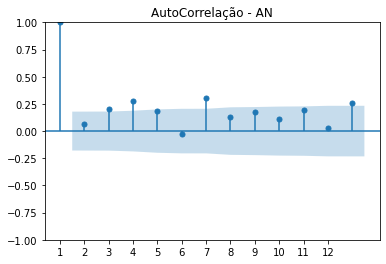

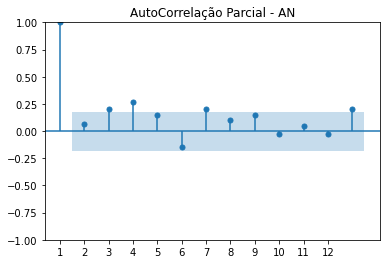

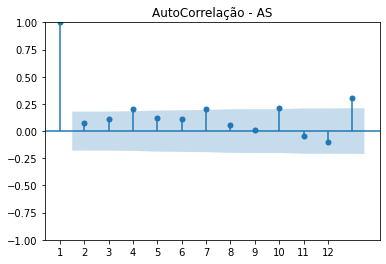

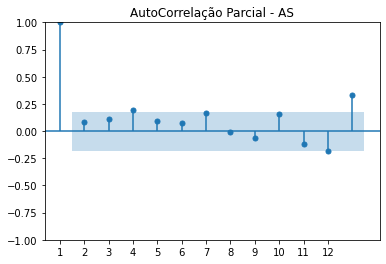

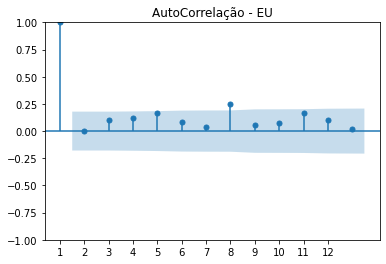

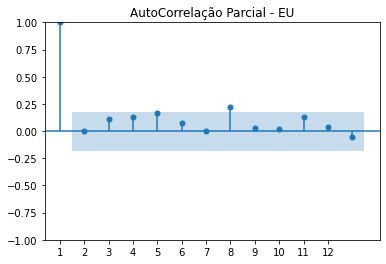

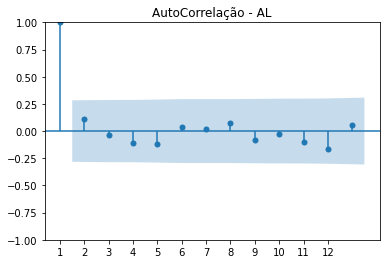

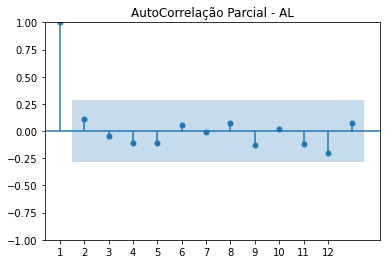

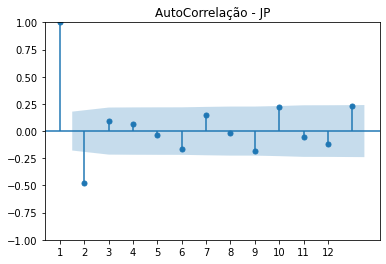

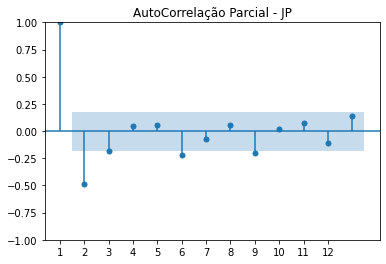

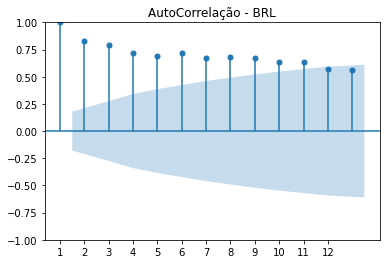

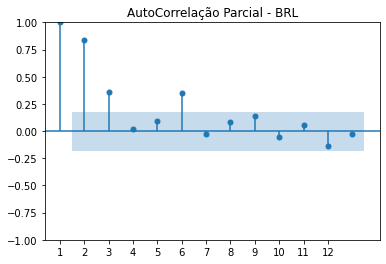

In [15]:
for market_values_df, market_name in zip(markets_values, markets_names):
    plot_acf(market_values_df[market_name], lags=12)
    plt.title("AutoCorrelação - "+ market_name)
    plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9,10,11],labels=[1,2,3,4,5,6,7,8,9,10,11,12])
    plt.show()

    plot_pacf(market_values_df[market_name], lags=12)
    plt.title("AutoCorrelação Parcial - "+ market_name)
    plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9,10,11],labels=[1,2,3,4,5,6,7,8,9,10,11,12])
    plt.show()